In [67]:
import pandas as pd

# Cargamos ignorando errores de fecha inicialmente para que no se detenga
df_estudiantes = pd.read_excel('MenteSana.xlsx', sheet_name='Estudiantes')

# Convertimos la columna 'Fecha de aplicación' a fecha real, 
# los valores erróneos (como el 6686090.0) se convertirán en NaT (Not a Time)
df_estudiantes['Fecha de aplicación'] = pd.to_datetime(df_estudiantes['Fecha de aplicación'], errors='coerce')

# Eliminamos filas que no tengan nombre de estudiante (filas basura al final)
df_estudiantes = df_estudiantes.dropna(subset=['Apellidos y nombres'])

print(f"Total de estudiantes cargados: {len(df_estudiantes)}")

Total de estudiantes cargados: 1237


/opt/anaconda3/envs/ml1/lib/python3.13/site-packages/openpyxl/worksheet/_reader.py:223: UserWarning: Cell P1000 is marked as a date but the serial value 6686090 is outside the limits for dates. The cell will be treated as an error.
  warn(msg)
/opt/anaconda3/envs/ml1/lib/python3.13/site-packages/openpyxl/worksheet/_reader.py:223: UserWarning: Cell P1001 is marked as a date but the serial value 6686090 is outside the limits for dates. The cell will be treated as an error.
  warn(msg)
/opt/anaconda3/envs/ml1/lib/python3.13/site-packages/openpyxl/worksheet/_reader.py:223: UserWarning: Cell P1002 is marked as a date but the serial value 6686090 is outside the limits for dates. The cell will be treated as an error.
  warn(msg)
/opt/anaconda3/envs/ml1/lib/python3.13/site-packages/openpyxl/worksheet/_reader.py:223: UserWarning: Cell P1003 is marked as a date but the serial value 6686090 is outside the limits for dates. The cell will be treated as an error.
  warn(msg)


In [68]:
import re

def to_camel_case(s):
    s = s.strip().lower()
    s = re.sub(r'[áà]', 'a', s)
    s = re.sub(r'[éè]', 'e', s)
    s = re.sub(r'[íì]', 'i', s)
    s = re.sub(r'[óò]', 'o', s)
    s = re.sub(r'[úù]', 'u', s)
    words = re.split(r'[\s_]+', s)
    return words[0] + ''.join(w.capitalize() for w in words[1:])

df_estudiantes.columns = [to_camel_case(c) for c in df_estudiantes.columns]
df_estudiantes.columns.tolist()

['codbusq',
 'santaC',
 'territorio',
 'ugt',
 'provincia',
 'distrito',
 'centroPoblado',
 'institucionEducativa',
 'codModular',
 'codLocal',
 'nivelModular',
 'grado',
 'seccion',
 'apellidosYNombres',
 'edad',
 'fechaDeAplicacion',
 'corteDeEvaluacion',
 'item1',
 'item2',
 'item3',
 'item4',
 'item5',
 'item6',
 'item7',
 'item8',
 'item9',
 'item10',
 '1.¿queSuelesHacerCuandoEstasEnojado?',
 '2.¿comoTeLlevasConTusCompañeros/as?¿queHacesParaLlevarteMejorConEllos/as?',
 '3.¿queHacesParaTomarBuenasDecisionesEnTuVidaDiaria?',
 '4.¿queTeGustariaAprenderOMejorarEnEstasSesiones?',
 'facilitador/a',
 'autoconciencia',
 'autocontrol',
 'concienciaSocial',
 'habilidadesRelacionales',
 'tomaDeDecisionesResponsables']

In [69]:
import unicodedata

df_estudiantes['apellidosYNombres'] = (
    df_estudiantes['apellidosYNombres']
    .str.strip()
    .str.normalize('NFKD')
    .apply(lambda x: ''.join(c for c in x if not unicodedata.combining(c)) if isinstance(x, str) else x)
)

In [70]:
# Duplicados: mismo nombre en mismo corte de evaluación
dupes = df_estudiantes[df_estudiantes.duplicated(subset=['apellidosYNombres', 'corteDeEvaluacion'], keep=False)]
dupes = dupes.sort_values(['apellidosYNombres', 'corteDeEvaluacion'])
print(f"Posibles duplicados: {len(dupes)}")
dupes[['apellidosYNombres', 'corteDeEvaluacion', 'institucionEducativa', 'grado', 'seccion']]

Posibles duplicados: 8


,apellidosYNombres,corteDeEvaluacion,institucionEducativa,grado,seccion
1020,Estrella,3er corte,TECNICO INDUSTRIAL,Pri-3ero,NaN
1193,Estrella,3er corte,86843,Pri-4rto,A
27,GUEVARA BARDALES BRITANIE CARLITA,2do corte,86221 SAN AGUSTIN,Sec-1ero,Única
1209,GUEVARA BARDALES BRITANIE CARLITA,2do corte,86221 SAN AGUSTIN,Sec-1ero,NaN
721,JAZMIN,2do corte,INDUSTRIAL PILOTO MIGUEL GRAU,Pri-5nto,U
798,JAZMIN,2do corte,86906,Pri-6xto,U
795,NEYMAR,2do corte,86906,Pri-6xto,U
799,NEYMAR,2do corte,86906,Pri-6xto,U


In [71]:
# Eliminar todas las filas que son duplicados exactos por nombre + corte
mask_dupes = df_estudiantes.duplicated(subset=['apellidosYNombres', 'corteDeEvaluacion'], keep=False)
df_estudiantes_clean = df_estudiantes[~mask_dupes]
print(f"Total estudiantes después de eliminar duplicados: {len(df_estudiantes_clean)}")

Total estudiantes después de eliminar duplicados: 1229


### Estudiantes con más de dos evaluaciones

In [72]:
# Mantener solo estudiantes con más de 1 evaluación
conteo = df_estudiantes_clean.groupby('apellidosYNombres')['corteDeEvaluacion'].nunique()
con_mas_de_1 = conteo[conteo > 1].index
df_estudiantes_clean = df_estudiantes_clean[df_estudiantes_clean['apellidosYNombres'].isin(con_mas_de_1)]
print(f"Estudiantes con más de 1 evaluación: {df_estudiantes_clean['apellidosYNombres'].nunique()}")
print(f"Total filas: {len(df_estudiantes_clean)}")

Estudiantes con más de 1 evaluación: 194
Total filas: 408


In [73]:
conteo = df_estudiantes_clean.groupby('apellidosYNombres')['corteDeEvaluacion'].nunique()
print(conteo.value_counts().sort_index().to_string())

corteDeEvaluacion
2    174
3     20


### Mapeo de Dimensiones


In [74]:
mapeo = {'Desarrollado': 3, 'Emergente': 1, 'En proceso': 2}
dims = ['autoconciencia', 'autocontrol', 'concienciaSocial', 'habilidadesRelacionales', 'tomaDeDecisionesResponsables']

for col in dims:
    df_estudiantes_clean[col] = df_estudiantes_clean[col].map(mapeo)

df_estudiantes_clean[dims].head()

,autoconciencia,autocontrol,concienciaSocial,habilidadesRelacionales,tomaDeDecisionesResponsables
1,1,3,2,2,2
2,2,3,2,2,1
3,1,2,3,2,1
4,2,3,2,3,3
5,1,1,3,3,2


In [87]:
# Ordenar por nombre y fecha
df_estudiantes_clean = df_estudiantes_clean.sort_values(['apellidosYNombres', 'fechaDeAplicacion'])

dims = ['autoconciencia', 'autocontrol', 'concienciaSocial', 'habilidadesRelacionales', 'tomaDeDecisionesResponsables']

# Primera y última evaluación por estudiante
primera = df_estudiantes_clean.groupby('apellidosYNombres').first().reset_index()
ultima = df_estudiantes_clean.groupby('apellidosYNombres').last().reset_index()

# Asignar código único
codigos = {nombre: f'EST_{str(i+1).zfill(4)}' for i, nombre in enumerate(primera['apellidosYNombres'])}
df_estudiantes_clean['codEstudiante'] = df_estudiantes_clean['apellidosYNombres'].map(codigos)

# Construir df comparativo
df_eval = pd.DataFrame({
    'codEstudiante': primera['apellidosYNombres'].map(codigos).values,
    'apellidosYNombres': primera['apellidosYNombres'].values,
    'codModular': primera['codModular'].values,
    'fechaPrimera': primera['fechaDeAplicacion'].values,
    'cortePrimera': primera['corteDeEvaluacion'].values,
    **{f'{d}_pre': primera[d].values for d in dims},
    'fechaUltima': ultima['fechaDeAplicacion'].values,
    'corteUltima': ultima['corteDeEvaluacion'].values,
    **{f'{d}_post': ultima[d].values for d in dims},
    **{f'{d}_diff': ultima[d].values - primera[d].values for d in dims},
})

df_eval.head()

,codEstudiante,apellidosYNombres,codModular,fechaPrimera,cortePrimera,autoconciencia_pre,autocontrol_pre,concienciaSocial_pre,habilidadesRelacionales_pre,tomaDeDecisionesResponsables_pre,...,autoconciencia_post,autocontrol_post,concienciaSocial_post,habilidadesRelacionales_post,tomaDeDecisionesResponsables_post,autoconciencia_diff,autocontrol_diff,concienciaSocial_diff,habilidadesRelacionales_diff,tomaDeDecisionesResponsables_diff
0,EST_0001,ALDAVE JESUS ALEXIS,735720,2025-07-08,1er corte,2,3,3,3,2,...,2,3,3,3,2,0,0,0,0,0
1,EST_0002,ALLAUCA CADENAS GIAMPIER WILLIAM,597609,2025-08-11,1er corte,2,1,3,2,2,...,2,2,2,2,2,0,1,-1,0,0
2,EST_0003,Abarca Alhuay Dayiro,577270,2025-07-22,1er corte,1,1,1,2,2,...,1,2,2,2,3,0,1,1,0,1
3,EST_0004,Alexa Garay Ramirez,542662,2025-08-12,1er corte,3,1,2,3,3,...,3,1,2,3,3,0,0,0,0,0
4,EST_0005,Alim Laguna,542662,2025-11-01,2do corte,2,2,3,1,2,...,2,3,2,2,3,0,1,-1,1,1


In [ ]:
#df_eval.to_excel('df_eval.xlsx', index=False)
#print("Exportado: df_eval.xlsx")

Exportado: df_eval.xlsx


In [82]:
dims = ['autoconciencia', 'autocontrol', 'concienciaSocial', 'habilidadesRelacionales', 'tomaDeDecisionesResponsables']

# Fila PRE
pre = df_eval[['codEstudiante', 'codModular', 'apellidosYNombres', 'fechaPrimera', 'cortePrimera'] + [f'{d}_pre' for d in dims]].copy()
pre.columns = ['codEstudiante', 'codModular', 'apellidosYNombres', 'fechaDeAplicacion', 'corteDeEvaluacion'] + dims
pre['evaluacion'] = 'pre'

# Fila POST
post = df_eval[['codEstudiante', 'codModular', 'apellidosYNombres', 'fechaUltima', 'corteUltima'] + [f'{d}_post' for d in dims]].copy()
post.columns = ['codEstudiante', 'codModular', 'apellidosYNombres', 'fechaDeAplicacion', 'corteDeEvaluacion'] + dims
post['evaluacion'] = 'post'

df_eval_long = pd.concat([pre, post]).sort_values(['codEstudiante', 'evaluacion']).reset_index(drop=True)

df_eval_long.to_excel('df_eval_long.xlsx', index=False)
print(f"Filas: {len(df_eval_long)}")
df_eval_long.head(6)

Filas: 388


,codEstudiante,codModular,apellidosYNombres,fechaDeAplicacion,corteDeEvaluacion,autoconciencia,autocontrol,concienciaSocial,habilidadesRelacionales,tomaDeDecisionesResponsables,evaluacion
0,EST_0001,735720,ALDAVE JESUS ALEXIS,2025-11-04,3er corte,2,3,3,3,2,post
1,EST_0001,735720,ALDAVE JESUS ALEXIS,2025-07-08,1er corte,2,3,3,3,2,pre
2,EST_0002,597609,ALLAUCA CADENAS GIAMPIER WILLIAM,2025-10-27,2do corte,2,2,2,2,2,post
3,EST_0002,597609,ALLAUCA CADENAS GIAMPIER WILLIAM,2025-08-11,1er corte,2,1,3,2,2,pre
4,EST_0003,577270,Abarca Alhuay Dayiro,2025-10-20,2do corte,1,2,2,2,3,post
5,EST_0003,577270,Abarca Alhuay Dayiro,2025-07-22,1er corte,1,1,1,2,2,pre


## Calculo de los PCA

### 1,2 autoconciencia
### 3,4 autocontrol
### 5,6 conciencia social
### 7,8 habilidades relacionales
### 9,10 toma de decisiones

In [83]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

dims = ['autoconciencia', 'autocontrol', 'concienciaSocial', 'habilidadesRelacionales', 'tomaDeDecisionesResponsables']

X = df_eval_long[dims].dropna()
X_scaled = StandardScaler().fit_transform(X)

pca = PCA()
pca.fit(X_scaled)

for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {var:.4f} ({var*100:.2f}%)")
print(f"\nVarianza acumulada PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"Varianza acumulada PC1+PC2: {sum(pca.explained_variance_ratio_[:2])*100:.2f}%")

PC1: 0.4064 (40.64%)
PC2: 0.1764 (17.64%)
PC3: 0.1449 (14.49%)
PC4: 0.1386 (13.86%)
PC5: 0.1335 (13.35%)

Varianza acumulada PC1: 40.64%
Varianza acumulada PC1+PC2: 58.29%


## Diferencia en promedio de cada dimensión

/var/folders/ky/nc_72jhs2jz7s9llnl6mxhdr0000gn/T/ipykernel_35042/3604448122.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(dims, rotation=30, ha='right')


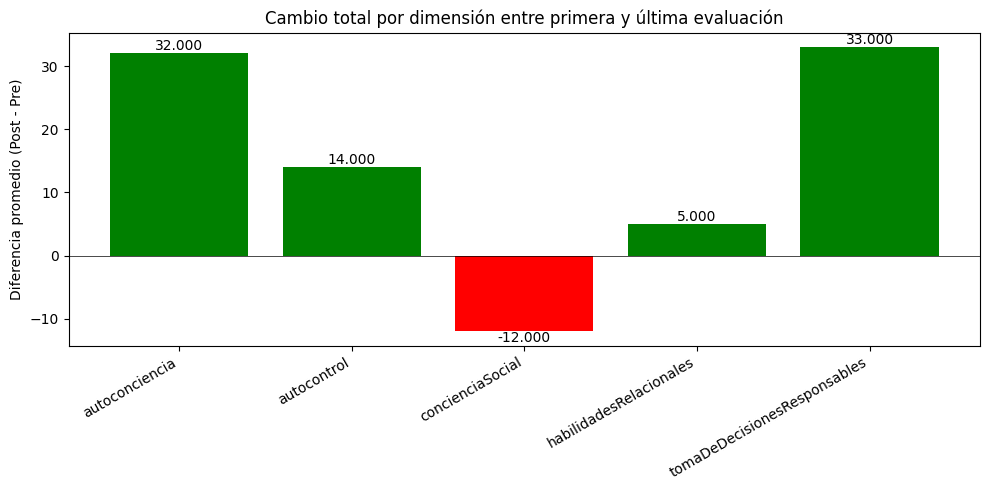

In [84]:
import matplotlib.pyplot as plt

dims = ['autoconciencia', 'autocontrol', 'concienciaSocial', 'habilidadesRelacionales', 'tomaDeDecisionesResponsables']

pre = df_eval_long[df_eval_long['evaluacion'] == 'pre'][dims].sum()
post = df_eval_long[df_eval_long['evaluacion'] == 'post'][dims].sum()
diff = post - pre

fig, ax = plt.subplots(figsize=(10, 5))
colors = ['green' if d >= 0 else 'red' for d in diff]
bars = ax.bar(dims, diff, color=colors)
ax.axhline(0, color='black', linewidth=0.5)
ax.set_ylabel('Diferencia promedio (Post - Pre)')
ax.set_title('Cambio total por dimensión entre primera y última evaluación')
ax.set_xticklabels(dims, rotation=30, ha='right')

for bar, val in zip(bars, diff):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val:.3f}', ha='center', va='bottom' if val >= 0 else 'top')

plt.tight_layout()
plt.show()

In [85]:
dims = ['autoconciencia', 'autocontrol', 'concienciaSocial', 'habilidadesRelacionales', 'tomaDeDecisionesResponsables']

# Pivotear para tener pre y post por estudiante
for d in dims:
    df_eval[f'{d}_diff'] = df_eval[f'{d}_post'] - df_eval[f'{d}_pre']

# Resumen por dimensión: mejoraron, igual, empeoraron
print("=== RESUMEN POR DIMENSIÓN ===\n")
for d in dims:
    mejoro = (df_eval[f'{d}_diff'] > 0).sum()
    igual = (df_eval[f'{d}_diff'] == 0).sum()
    empeoro = (df_eval[f'{d}_diff'] < 0).sum()
    print(f"{d}:")
    print(f"  Mejoraron: {mejoro} | Igual: {igual} | Empeoraron: {empeoro}")
    print(f"  Diff total: {df_eval[f'{d}_diff'].sum()} | Diff promedio: {df_eval[f'{d}_diff'].mean():.3f}\n")

# Mostrar estudiantes que empeoraron en alguna dimensión
print("=== ESTUDIANTES QUE EMPEORARON ===")
cols_diff = [f'{d}_diff' for d in dims]
empeoraron = df_eval[df_eval[cols_diff].min(axis=1) < 0][['codEstudiante', 'apellidosYNombres', 'cortePrimera', 'corteUltima'] + cols_diff]
print(f"Total: {len(empeoraron)}")
empeoraron

=== RESUMEN POR DIMENSIÓN ===

autoconciencia:
  Mejoraron: 61 | Igual: 95 | Empeoraron: 38
  Diff total: 32 | Diff promedio: 0.165

autocontrol:
  Mejoraron: 59 | Igual: 86 | Empeoraron: 49
  Diff total: 14 | Diff promedio: 0.072

concienciaSocial:
  Mejoraron: 47 | Igual: 91 | Empeoraron: 56
  Diff total: -12 | Diff promedio: -0.062

habilidadesRelacionales:
  Mejoraron: 43 | Igual: 108 | Empeoraron: 43
  Diff total: 5 | Diff promedio: 0.026

tomaDeDecisionesResponsables:
  Mejoraron: 63 | Igual: 94 | Empeoraron: 37
  Diff total: 33 | Diff promedio: 0.170

=== ESTUDIANTES QUE EMPEORARON ===
Total: 125


,codEstudiante,apellidosYNombres,cortePrimera,corteUltima,autoconciencia_diff,autocontrol_diff,concienciaSocial_diff,habilidadesRelacionales_diff,tomaDeDecisionesResponsables_diff
1,EST_0002,ALLAUCA CADENAS GIAMPIER WILLIAM,1er corte,2do corte,0,1,-1,0,0
4,EST_0005,Alim Laguna,2do corte,3er corte,0,1,-1,1,1
5,EST_0006,Anabel Castro Calderon,2do corte,3er corte,-1,1,-1,-1,-1
6,EST_0007,Antony Rodrigo Garay Aquino,1er corte,3er corte,1,0,0,-1,0
7,EST_0008,Aponte Requena Kevin,1er corte,2do corte,1,0,-1,0,0
...,...,...,...,...,...,...,...,...,...
186,EST_0187,Yeli Maritza Castro Aquino,1er corte,3er corte,0,1,-1,0,0
188,EST_0189,Yenci Ugarte Castro,2do corte,3er corte,0,0,0,-1,1
190,EST_0191,Yin,1er corte,2do corte,1,0,-2,1,0
191,EST_0192,Yissle,1er corte,3er corte,-1,1,0,0,1


In [86]:
cs_neg = df_eval[df_eval['concienciaSocial_diff'] < 0][['codEstudiante', 'apellidosYNombres', 'cortePrimera', 'corteUltima', 'concienciaSocial_pre', 'concienciaSocial_post', 'concienciaSocial_diff']].sort_values('concienciaSocial_diff', ascending=False)
print(f"Estudiantes que empeoraron en Conciencia Social: {len(cs_neg)}")
cs_neg

Estudiantes que empeoraron en Conciencia Social: 56


,codEstudiante,apellidosYNombres,cortePrimera,corteUltima,concienciaSocial_pre,concienciaSocial_post,concienciaSocial_diff
1,EST_0002,ALLAUCA CADENAS GIAMPIER WILLIAM,1er corte,2do corte,3,2,-1
149,EST_0150,Rivera Zambrano Franck,1er corte,2do corte,2,1,-1
113,EST_0114,MEZA SALINAS GIANELLA,1er corte,2do corte,3,2,-1
115,EST_0116,Maguina Cosme Saray Gricell,1er corte,2do corte,3,2,-1
119,EST_0120,Marcelo Huerta Romina Valeria,1er corte,2do corte,2,1,-1
123,EST_0124,Montesinos Isidro Luis Daniel,1er corte,2do corte,3,2,-1
127,EST_0128,Moreno Vasquez Eymi Katherine Selena,1er corte,2do corte,3,2,-1
129,EST_0130,Neylin,2do corte,3er corte,3,2,-1
132,EST_0133,OBREGON MORENO KARENKA,1er corte,2do corte,3,2,-1
136,EST_0137,PIZANGO AZANA JACK WAGNER,1er corte,2do corte,3,2,-1


In [ ]:
df_sesiones = pd.read_excel('Sesiones.xlsx', sheet_name='Hoja1')
df_sesiones = df_sesiones[['Sesiones Estudiante ejecutadas', 'CODIGO MODULAR']]

import re

def to_camel_case(s):
    s = s.strip().lower()
    for a, b in [('á','a'),('é','e'),('í','i'),('ó','o'),('ú','u'),('ñ','n')]:
        s = s.replace(a, b)
    s = re.sub(r'[¿?./,()°]', '', s)
    words = re.split(r'[\s_]+', s)
    return words[0] + ''.join(w.capitalize() for w in words[1:])

df_sesiones.columns = [to_camel_case(c) for c in df_sesiones.columns]
print(df_sesiones.columns.tolist())


['sesionesEstudianteEjecutadas', 'codigoModular']


,sesionesEstudianteEjecutadas,codigoModular
0,6,411447
1,6,415166
2,6,681478
3,5,247650
4,5,577270


In [62]:
df_sesiones

,sesionesEstudianteEjecutadas,codigoModular
0,6,411447
1,6,415166
2,6,681478
3,5,247650
4,5,577270
5,6,247668
6,6,1090851
7,5,476531
8,5,343640
9,14,681346


In [88]:
df_eval = df_eval.merge(df_sesiones, left_on='codModular', right_on='codigoModular', how='left').drop(columns='codigoModular')
df_eval.head()

,codEstudiante,apellidosYNombres,codModular,fechaPrimera,cortePrimera,autoconciencia_pre,autocontrol_pre,concienciaSocial_pre,habilidadesRelacionales_pre,tomaDeDecisionesResponsables_pre,...,autocontrol_post,concienciaSocial_post,habilidadesRelacionales_post,tomaDeDecisionesResponsables_post,autoconciencia_diff,autocontrol_diff,concienciaSocial_diff,habilidadesRelacionales_diff,tomaDeDecisionesResponsables_diff,sesionesEstudianteEjecutadas
0,EST_0001,ALDAVE JESUS ALEXIS,735720,2025-07-08,1er corte,2,3,3,3,2,...,3,3,3,2,0,0,0,0,0,15
1,EST_0002,ALLAUCA CADENAS GIAMPIER WILLIAM,597609,2025-08-11,1er corte,2,1,3,2,2,...,2,2,2,2,0,1,-1,0,0,17
2,EST_0003,Abarca Alhuay Dayiro,577270,2025-07-22,1er corte,1,1,1,2,2,...,2,2,2,3,0,1,1,0,1,5
3,EST_0004,Alexa Garay Ramirez,542662,2025-08-12,1er corte,3,1,2,3,3,...,1,2,3,3,0,0,0,0,0,5
4,EST_0005,Alim Laguna,542662,2025-11-01,2do corte,2,2,3,1,2,...,3,2,2,3,0,1,-1,1,1,5


=== Resultados Regresión Lineal ===

autoconciencia                      β=+0.0003  R²=0.0000  intercepto=0.1626
autocontrol                         β=+0.0007  R²=0.0000  intercepto=0.0671
concienciaSocial                    β=-0.0244  R²=0.0142  intercepto=0.1203
habilidadesRelacionales             β=+0.0010  R²=0.0000  intercepto=0.0183
tomaDeDecisionesResponsables        β=+0.0174  R²=0.0068  intercepto=0.0404


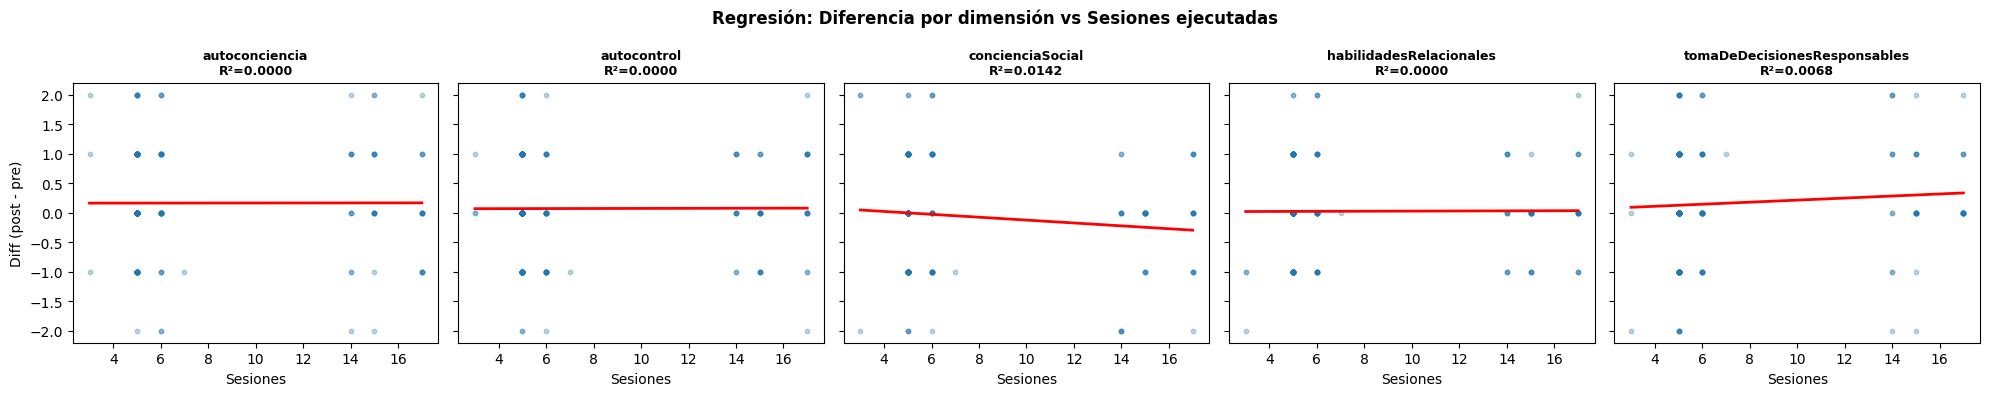

In [90]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

dims_diff = ['autoconciencia_diff', 'autocontrol_diff', 'concienciaSocial_diff', 'habilidadesRelacionales_diff', 'tomaDeDecisionesResponsables_diff']

df_reg = df_eval.dropna(subset=['sesionesEstudianteEjecutadas'])
X = df_reg[['sesionesEstudianteEjecutadas']].values

fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

print("=== Resultados Regresión Lineal ===\n")
for ax, dim in zip(axes, dims_diff):
    y = df_reg[dim].values
    reg = LinearRegression().fit(X, y)
    r2 = reg.score(X, y)
    
    print(f"{dim.replace('_diff', ''):35s} β={reg.coef_[0]:+.4f}  R²={r2:.4f}  intercepto={reg.intercept_:.4f}")
    
    ax.scatter(X, y, alpha=0.3, s=10)
    x_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    ax.plot(x_line, reg.predict(x_line), color='red', linewidth=2)
    ax.set_title(f"{dim.replace('_diff', '')}\nR²={r2:.4f}", fontsize=9, fontweight='bold')
    ax.set_xlabel('Sesiones')

axes[0].set_ylabel('Diff (post - pre)')
plt.suptitle('Regresión: Diferencia por dimensión vs Sesiones ejecutadas', fontweight='bold')
plt.tight_layout()
plt.show()

In [91]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

dims_diff = ['autoconciencia_diff', 'autocontrol_diff', 'concienciaSocial_diff', 'habilidadesRelacionales_diff', 'tomaDeDecisionesResponsables_diff']
df_reg = df_eval.dropna(subset=['sesionesEstudianteEjecutadas'])

print("=== 1. Distribución de sesiones ===")
print(df_reg['sesionesEstudianteEjecutadas'].describe())
print(f"\nValores únicos: {sorted(df_reg['sesionesEstudianteEjecutadas'].unique())}")

print("\n=== 2. Correlación de Spearman (mejor para datos ordinales) ===\n")
for dim in dims_diff:
    rho, pval = stats.spearmanr(df_reg['sesionesEstudianteEjecutadas'], df_reg[dim])
    sig = '***' if pval < 0.01 else '**' if pval < 0.05 else '*' if pval < 0.1 else 'ns'
    print(f"{dim.replace('_diff',''):35s} rho={rho:+.4f}  p={pval:.4f} {sig}")

print("\n=== 3. Promedio diff por grupo de sesiones ===\n")
df_reg['grupoSesiones'] = pd.cut(df_reg['sesionesEstudianteEjecutadas'], bins=[0, 5, 10, 20], labels=['1-5', '6-10', '11+'])
tabla = df_reg.groupby('grupoSesiones')[dims_diff].mean().round(3)
print(tabla)

print("\n=== 4. Test Kruskal-Wallis por grupo ===\n")
for dim in dims_diff:
    grupos = [g[dim].values for _, g in df_reg.groupby('grupoSesiones') if len(g) > 0]
    if len(grupos) >= 2:
        h, p = stats.kruskal(*grupos)
        sig = '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.1 else 'ns'
        print(f"{dim.replace('_diff',''):35s} H={h:.4f}  p={p:.4f} {sig}")

=== 1. Distribución de sesiones ===
count    194.000000
mean       7.463918
std        4.357263
min        3.000000
25%        5.000000
50%        5.000000
75%        6.000000
max       17.000000
Name: sesionesEstudianteEjecutadas, dtype: float64

Valores únicos: [np.int64(3), np.int64(5), np.int64(6), np.int64(7), np.int64(14), np.int64(15), np.int64(17)]

=== 2. Correlación de Spearman (mejor para datos ordinales) ===

autoconciencia                      rho=+0.0226  p=0.7540 ns
autocontrol                         rho=-0.0607  p=0.4004 ns
concienciaSocial                    rho=-0.0636  p=0.3784 ns
habilidadesRelacionales             rho=+0.0430  p=0.5515 ns
tomaDeDecisionesResponsables        rho=+0.0800  p=0.2675 ns

=== 3. Promedio diff por grupo de sesiones ===

               autoconciencia_diff  autocontrol_diff  concienciaSocial_diff  \
grupoSesiones                                                                 
1-5                          0.143             0.134           

/var/folders/ky/nc_72jhs2jz7s9llnl6mxhdr0000gn/T/ipykernel_35042/934435009.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabla = df_reg.groupby('grupoSesiones')[dims_diff].mean().round(3)
/var/folders/ky/nc_72jhs2jz7s9llnl6mxhdr0000gn/T/ipykernel_35042/934435009.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grupos = [g[dim].values for _, g in df_reg.groupby('grupoSesiones') if len(g) > 0]


In [92]:
# 1. Ver si la institución o facilitador explican más varianza
print("=== Diferencia promedio por institución educativa ===")
by_ie = df_eval.dropna(subset=['sesionesEstudianteEjecutadas']).groupby('codModular').agg(
    n=('codEstudiante', 'count'),
    sesiones=('sesionesEstudianteEjecutadas', 'mean'),
    **{d: (d, 'mean') for d in dims_diff}
).round(3)
print(by_ie.sort_values('n', ascending=False))

# 2. Chi-cuadrado: ¿mejoraron o no vs grupo de sesiones?
from scipy.stats import chi2_contingency

dims_diff = ['autoconciencia_diff', 'autocontrol_diff', 'concienciaSocial_diff', 'habilidadesRelacionales_diff', 'tomaDeDecisionesResponsables_diff']
df_reg = df_eval.dropna(subset=['sesionesEstudianteEjecutadas']).copy()
df_reg['grupoSesiones'] = pd.cut(df_reg['sesionesEstudianteEjecutadas'], bins=[0, 5, 10, 20], labels=['1-5', '6-10', '11+'])

print("\n=== Chi-cuadrado: ¿Mejoraron (diff>0) vs grupo de sesiones? ===\n")
for dim in dims_diff:
    df_reg[f'{dim}_mejoro'] = (df_reg[dim] > 0).astype(int)
    tabla = pd.crosstab(df_reg['grupoSesiones'], df_reg[f'{dim}_mejoro'])
    chi2, p, dof, expected = chi2_contingency(tabla)
    sig = '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.1 else 'ns'
    print(f"{dim.replace('_diff',''):35s} χ²={chi2:.4f}  p={p:.4f} {sig}")

=== Diferencia promedio por institución educativa ===
             n  sesiones  autoconciencia_diff  autocontrol_diff  \
codModular                                                        
542662      58       5.0                0.069             0.190   
247650      31       5.0                0.226             0.065   
681478      16       6.0                0.312            -0.125   
577270      13       5.0               -0.308            -0.385   
597609      13      17.0               -0.077             0.231   
415166       9       6.0               -0.111            -0.222   
415513       8      15.0                0.375             0.000   
645010       7      14.0               -0.143             0.429   
247668       5       6.0                0.600            -0.200   
597872       5       5.0                1.400             1.200   
343640       5       5.0                0.000             0.200   
476531       4       5.0                0.250             0.000   
681346  